In [1]:
%matplotlib inline

import argparse
from collections import namedtuple
from copy import deepcopy
from itertools import count
import math
import random
from time import time

from IPython import display
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms


plt.ion()
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
parser = argparse.ArgumentParser()

# data
parser.add_argument('--resize_w', type=int, default=40)
parser.add_argument('--resize_h', type=int, default=40)
# model
parser.add_argument('--replay_memory_size', type=int, default=10000)
# training
parser.add_argument('--n_episodes', type=int, default=10)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--gamma', type=float, default=0.999)
parser.add_argument('--eps_start', type=float, default=0.9)
parser.add_argument('--eps_end', type=float, default=0.05)
parser.add_argument('--eps_decay', type=int, default=200)
parser.add_argument('--update_target_net_every_x_episodes', type=int, default=10)


args, _ = parser.parse_known_args()
args.n_episodes = 500

In [3]:
env = gym.make('CartPole-v0').unwrapped

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [5]:
class DQN(nn.Module):
    def __init__(self, h, w, n_outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def calc_feature_map_size(size, kernel_size=5, stride=2):
            return (size - kernel_size) // stride + 1
        
        n_conv_layers = 3
        feat_w, feat_h = w, h
        for _ in range(n_conv_layers):
            feat_w = calc_feature_map_size(feat_w)
            feat_h = calc_feature_map_size(feat_h)
        
        self.fc = nn.Linear(feat_w * feat_h * 32, n_outputs)
        
    def forward(self, x):
        bs = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(bs, -1)
        x = self.fc(x)
        return x

In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((args.resize_w, args.resize_h), interpolation=Image.CUBIC),
    transforms.ToTensor(),
])

In [7]:
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)

In [8]:
def get_screen(env):
    # (c, h, w)
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_h, screen_w = screen.shape
    screen = screen[:, int(screen_w * 0.4):int(screen_h * 0.8)]
    view_width = int(screen_w * 0.6)

    cart_location = get_cart_location(screen_w)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_w - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)
    screen = screen[:, :, slice_range]
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    screen = torch.from_numpy(screen)
    # (bs, c, h, w)
    screen = transform(screen).unsqueeze(0).to(device)
    return screen

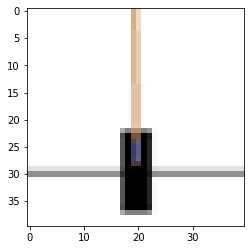

In [9]:
env.reset()
plt.figure()
_im = get_screen(env).cpu().squeeze().permute(1, 2, 0).numpy()
plt.imshow(_im, interpolation='none')
plt.show()

In [10]:
init_screen = get_screen(env)
_, _, screen_h, screen_w = init_screen.shape

n_actions = env.action_space.n

# model
policy_net = DQN(screen_h, screen_w, n_actions).to(device)
target_net = DQN(screen_h, screen_w, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
# optim
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(args.replay_memory_size)

In [11]:
steps_done = 0

def select_action(state, args):
    global steps_done

    sample = random.random()
    eps_threshold = args.eps_end + (args.eps_start - args.eps_end) * math.exp(-1. * steps_done / args.eps_decay)
    steps_done += 1
    
    if sample > eps_threshold:
        with torch.no_grad():
            action = policy_net(state).max(dim=1)[1].view(1, 1)
            return action
    else:
        action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
        return action

In [12]:
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    plt.pause(0.001)
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [13]:
def train(args):
    if len(memory) < args.batch_size:
        return
    
    transitions = memory.sample(args.batch_size)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(args.batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = reward_batch + args.gamma * next_state_values
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [14]:
total_rewards = []
durations = []
for episode_i in range(args.n_episodes):
    g = 0
    
    env.reset()
    last_screen = get_screen(env)
    current_screen = get_screen(env)
    state = current_screen - last_screen
    
    for t in count():
        action = select_action(state, args)
        _, reward, done, _ = env.step(action.item())
        g += reward
        reward = torch.tensor([reward], device=device)
        
        last_screen = current_screen
        current_screen = get_screen(env)
        if done:
            next_state = None
        else:
            next_state = current_screen - last_screen

        memory.push(state, action, next_state, reward)
        state = next_state
        
        train(args)
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    if (episode_i + 1) % args.update_target_net_every_x_episodes == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    total_rewards.append(g)
    durations.append(t + 1)
    print('Episode {} - Return {} Duration {}'.format(episode_i + 1, g, t + 1))

print('Finished')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Episode 500 - Return 59.0 Duration 59
Finished


<Figure size 432x288 with 0 Axes>

In [15]:
assert len(total_rewards) == len(durations) == args.n_episodes

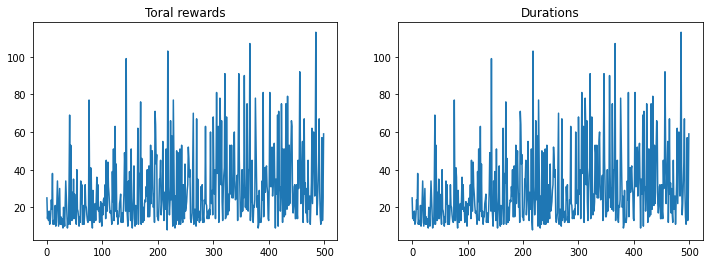

In [16]:
plt.figure(figsize=(2 * 6, 4))
plt.subplot(1, 2, 1)
plt.plot(total_rewards)
plt.title('Toral rewards')

plt.subplot(1, 2, 2)
plt.plot(durations)
plt.title('Durations')
plt.show()